In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('emails.csv')

In [3]:
df.head(5)

,Email No.,the,to,ect,and,for,of,a,you,hou,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,Email 1,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Email 2,8,13,24,6,6,2,102,1,27,...,0,0,0,0,0,0,0,1,0,0
2,Email 3,0,0,1,0,0,0,8,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Email 4,0,5,22,0,5,1,51,2,10,...,0,0,0,0,0,0,0,0,0,0
4,Email 5,7,6,17,1,5,2,57,0,9,...,0,0,0,0,0,0,0,1,0,0


In [4]:
df['Email No.'].is_unique

True

In [5]:
df = df.drop(columns=['Email No.'])

In [6]:
X= df.drop(columns='Prediction')
y=df['Prediction']

In [17]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler#, RobustScaler, QuantileTransformer, PowerTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, average_precision_score, roc_curve
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit, KFold


from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

In [18]:
X= df.drop(columns='Prediction')
y=df['Prediction']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

7 Classification models will be compared. RandomForest and ADABoost are tested with more estimators to further evaluation of data. SVM is compared using Linear kernel vs. Sigmoid kernel.

In [20]:
classifiers = {
    'LGBM': LGBMClassifier(verbose=0),
    'CatBoost':CatBoostClassifier(silent=True),
    'LogisticRegression': LogisticRegression(max_iter=500),
    'RandomForest100': RandomForestClassifier(),
    'RandomForest200': RandomForestClassifier(n_estimators=200),
    'SVMLinear': SVC(kernel='linear', probability=True),
    'SVMSigmoid': SVC(kernel='sigmoid', probability=True),
    'GradientBoost': GradientBoostingClassifier(),
    'ADABoost100': AdaBoostClassifier(n_estimators=100),
    'ADABoost200': AdaBoostClassifier(n_estimators=200),
}

In [21]:
def sc_pca_class_test(X, y, scaler, reduce, components, ts, classifier, split_method, rs):

    if scaler:
        X_scaled = scaler.fit_transform(X)
    else:
        X_scaled = None
    '''
    
    '''
    r_params = {'n_components': components, 'random_state': rs}
    
    r_dc = {'pca': PCA(**r_params),
             'svd' : TruncatedSVD(**r_params),
             'tsne': TSNE(method='exact', n_components= components, random_state= rs),
             'lda_svd' : LDA(n_components= 2, solver= 'svd')}
    
    if reduce in r_dc.keys():
        if reduce[:3].lower() == 'lda':
            X_reduced = r_dc[reduce].fit_transform(X_scaled, y)
        else:
            X_reduced = r_dc[reduce].fit_transform(X_scaled)
    else: 
        X_reduced = X_scaled.copy()   
        
    n_splits=int((1/ts))
    
    split_dc = {
           'skf' : StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=rs),
            'sss' : StratifiedShuffleSplit(n_splits=n_splits, test_size=ts, random_state=rs),    
            'kf': KFold(n_splits=n_splits, shuffle=True, random_state=rs)
    }
    
    if split_method == 'tt':

        X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=ts, random_state=rs)
        
    elif split_method in split_dc.keys():
        
        for train_index, test_index in split_dc[split_method].split(X_reduced, y):
            X_train, X_test = X_reduced[train_index], X_reduced[test_index]
            y_train, y_test = y[train_index], y[test_index]
        
    else:
        print(split_method + ' not allowed')
        return None
    
    classifier.fit(X_train, y_train)    
    
    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)[:, 1] if hasattr(classifier, 'predict_proba') else None
    
    # Calculate all metrics
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else 'N/A'
    }
    
    # Calculate precision-recall curve data
    if y_pred_proba is not None:
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
        ap_score = average_precision_score(y_test, y_pred_proba)
        metrics.update({
            'precision_recall': (precision, recall, thresholds),
            'average_precision': ap_score
        })
        
        fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
        roc_auc = roc_auc_score(y_test, y_pred_proba)   
        metrics.update({'roc_curve': (fpr, tpr, roc_thresholds),
        'roc_auc': roc_auc
        })
        
    return metrics

Comparison of each Model listed above    
with 3 split methods: Train Test Split, Stratified KFold, StratifiedShuffleSplit   
 & 3 scaling methods: StandardScaler(), MinMaxScaler(), and MaxAbsScaler()
 
 Returning the metrics required to plot roc_auc & precision-recall curves as well as the precision, recall, accuracy, average precision.

In [22]:
metrics1 = {}

    
for c_name, classifier in classifiers.items():
    for split_method in ['tt','skf', 'sss']:
        for sc in [MinMaxScaler(), StandardScaler(), MaxAbsScaler()]:
            scores = sc_pca_class_test(X, y, sc, None, 50, 0.2, classifier, split_method, 99)
            key = c_name + '_' + split_method + '_' + sc.__class__.__name__

            if key not in metrics1:
                metrics1[key] = {}

            metrics1[key].update(scores)



In [618]:
results_df = pd.DataFrame.from_dict(metrics1, orient='index').sort_values(by=['f1', 'roc_auc'], ascending=False).reset_index()
results_df[['model', 'split_method', 'scaler']] = results_df['index'].str.split('_', expand=True)                          

### Precision: Top 10
>"Relaxed Spam Filter" Highest number of real emails allowed into inbox (and least real number filtered as spam), but also some spam emails allowed into inbox.

In [616]:
results_df.sort_values(by=['precision','f1'],ascending=False).head(10)[['model','split_method','scaler','precision','f1','recall','roc_auc']]

,model,split_method,scaler,precision,f1,recall,roc_auc
55,LogisticRegression,sss,MinMaxScaler,0.978723,0.948454,0.920000,0.996109
56,LogisticRegression,sss,MaxAbsScaler,0.978723,0.948454,0.920000,0.996109
15,RandomForest200,tt,MaxAbsScaler,0.977492,0.965079,0.952978,0.996894
16,CatBoost,sss,MinMaxScaler,0.976027,0.962838,0.950000,0.996966
17,CatBoost,sss,StandardScaler,0.976027,0.962838,0.950000,0.996966
18,CatBoost,sss,MaxAbsScaler,0.976027,0.962838,0.950000,0.996966
6,CatBoost,tt,MinMaxScaler,0.974603,0.968454,0.962382,0.998183
7,CatBoost,tt,StandardScaler,0.974603,0.968454,0.962382,0.998183
8,CatBoost,tt,MaxAbsScaler,0.974603,0.968454,0.962382,0.998183
42,LogisticRegression,skf,MinMaxScaler,0.972125,0.950596,0.930000,0.994909


### Recall: Top 10
>"Aggressive Spam Filter" Highest number of correct spam email classification, but also some real emails are classified as spam. 

In [706]:
results_df.sort_values(by=['recall', 'f1'],ascending=False).head(10)[['model','split_method','scaler','recall','f1','precision','roc_auc']]

,model,split_method,scaler,recall,f1,precision,roc_auc
index,,,,,,,
LGBM_skf_StandardScaler,LGBM,skf,StandardScaler,0.983333,0.968801,0.954693,0.998401
LGBM_skf_MinMaxScaler,LGBM,skf,MinMaxScaler,0.983333,0.968801,0.954693,0.998397
LGBM_skf_MaxAbsScaler,LGBM,skf,MaxAbsScaler,0.983333,0.968801,0.954693,0.998397
SVMLinear_skf_MaxAbsScaler,SVMLinear,skf,MaxAbsScaler,0.983333,0.962480,0.942492,0.994773
SVMLinear_skf_MinMaxScaler,SVMLinear,skf,MinMaxScaler,0.983333,0.962480,0.942492,0.994768
ADABoost200_tt_MinMaxScaler,ADABoost200,tt,MinMaxScaler,0.978056,0.967442,0.957055,0.997680
ADABoost200_tt_StandardScaler,ADABoost200,tt,StandardScaler,0.978056,0.967442,0.957055,0.997680
ADABoost200_tt_MaxAbsScaler,ADABoost200,tt,MaxAbsScaler,0.978056,0.967442,0.957055,0.997680
LGBM_tt_MinMaxScaler,LGBM,tt,MinMaxScaler,0.974922,0.965839,0.956923,0.998152


### f1-score: Top 10
> Accuracy that is weighted to account for class imbalance. Good measure of balanced performance. 

In [617]:
results_df.sort_values(by='f1',ascending=False).head(10)[['model','split_method','scaler','f1','precision','recall','roc_auc']]

,model,split_method,scaler,f1,precision,recall,roc_auc
0,LGBM,sss,MinMaxScaler,0.970100,0.966887,0.973333,0.997351
1,LGBM,sss,StandardScaler,0.970100,0.966887,0.973333,0.997351
2,LGBM,sss,MaxAbsScaler,0.970100,0.966887,0.973333,0.997351
3,LGBM,skf,StandardScaler,0.968801,0.954693,0.983333,0.998401
4,LGBM,skf,MinMaxScaler,0.968801,0.954693,0.983333,0.998397
5,LGBM,skf,MaxAbsScaler,0.968801,0.954693,0.983333,0.998397
6,CatBoost,tt,MinMaxScaler,0.968454,0.974603,0.962382,0.998183
7,CatBoost,tt,StandardScaler,0.968454,0.974603,0.962382,0.998183
8,CatBoost,tt,MaxAbsScaler,0.968454,0.974603,0.962382,0.998183
11,ADABoost200,tt,MaxAbsScaler,0.967442,0.957055,0.978056,0.997680


While some models are clearly better than others, it is important to identify the performance of each scaling and split method. 

In [619]:
results_df = results_df.set_index('index') 

avg_precision_mean_scores = {}
f1_mean_score = {}
recall_mean_score = {}

top_df = results_df[results_df.precision > 0.90]

for s in top_df.split_method.unique():
    avg_precision_mean_scores[s] = top_df[top_df.split_method == s].average_precision.mean()
    f1_mean_score[s] = top_df[top_df.split_method == s].f1.mean()  
    recall_mean_score[s] = top_df[top_df.split_method == s].recall.mean()
    
for m in top_df.model.unique():
    avg_precision_mean_scores[m] = top_df[top_df.model == m].average_precision.mean()
    f1_mean_score[m] = top_df[top_df.model == m].f1.mean()
    recall_mean_score[m] = top_df[top_df.model == m].recall.mean()    
    
for sc in top_df.scaler.unique():
    avg_precision_mean_scores[sc] = top_df[top_df.scaler == sc].average_precision.mean()    
    f1_mean_score[sc] = top_df[top_df.scaler == sc].f1.mean()    
    recall_mean_score[sc] = top_df[top_df.scaler == sc].recall.mean()    

In [620]:
sp_dc = {'tt':'Test_Train_Split','sss':'StratifiedShuffleSplit','skf':'StratifiedKFold'}

In [621]:
mean_df = pd.DataFrame({
    'avg precision': avg_precision_mean_scores,
    'f1': f1_mean_score,
    'recall': recall_mean_score
})

mean_df = mean_df.rename(index=sp_dc)

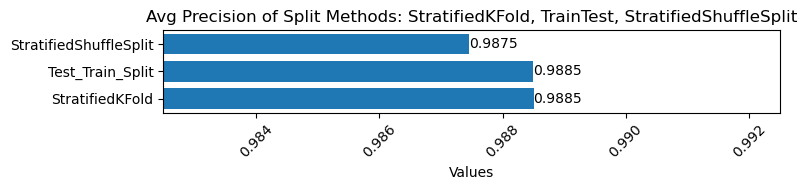

In [622]:
plot_bar_graphs(mean_df[mean_df.index.isin([sp_dc[k] for k in top_df.split_method.unique()])].sort_values(by='avg precision', ascending=False), ['avg precision'], x_label='', title='Avg Precision of Split Methods: StratifiedKFold, TrainTest, StratifiedShuffleSplit', horizontal=True, bar_min=0.9825, bar_max=0.9925, figsize=(8,2),grid=False, legend=False, decimal=4)

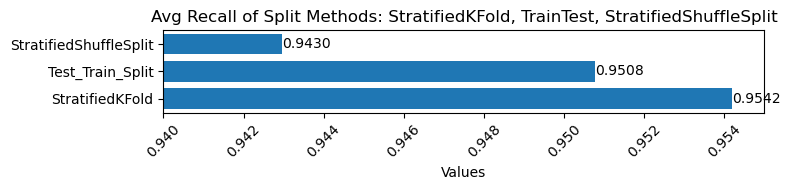

In [520]:
plot_bar_graphs(mean_df[mean_df.index.isin([sp_dc[k] for k in top_df.split_method.unique()])].sort_values(by='recall', ascending=False), ['recall'], x_label='', title='Avg Recall of Split Methods: StratifiedKFold, TrainTest, StratifiedShuffleSplit', horizontal=True, bar_min=0.94,bar_max=0.955, figsize=(8,2),grid=False, legend=False, decimal=4)

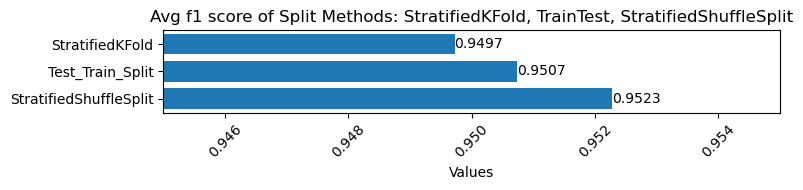

In [521]:
plot_bar_graphs(mean_df[mean_df.index.isin([sp_dc[k] for k in top_df.split_method.unique()])].sort_values(by='f1', ascending=False), ['f1'], x_label='', title='Avg f1 score of Split Methods: StratifiedKFold, TrainTest, StratifiedShuffleSplit', horizontal=True, bar_min=0.945,bar_max=0.955, figsize=(8,2),grid=False, legend=False, decimal=4)

     Precision:  StratifiedKFold, Train Test Split  
     Recall:  StratifiedKFold  
     F1:  StratifiedShuffleSplit  
    
### Winner: *Train Test Split*  
    
    
Precision will be prioritized for this model. Additionally, it showed superior overall performance to SKF while SSS was the least precise split method. 

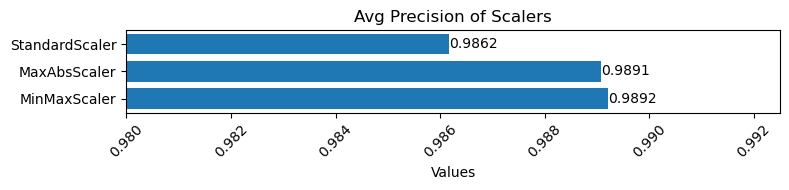

In [522]:
plot_bar_graphs(mean_df[mean_df.index.isin(top_df.scaler.unique())].sort_values(by='avg precision', ascending=False), ['avg precision'], title='Avg Precision of Scalers', x_label='', horizontal=True, bar_min=0.98,bar_max=0.9925, figsize=(8,2),grid=False, legend=False, decimal=4)

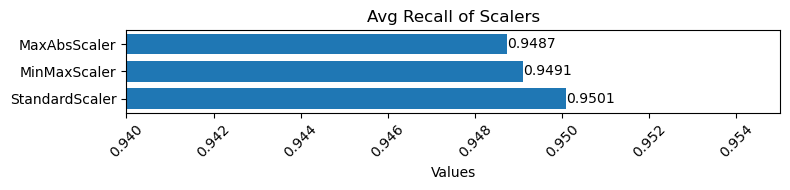

In [523]:
plot_bar_graphs(mean_df[mean_df.index.isin(top_df.scaler.unique())].sort_values(by='recall', ascending=False), ['recall'], x_label='', title='Avg Recall of Scalers', horizontal=True, bar_min=0.94,bar_max=0.955, figsize=(8,2),grid=False, legend=False, decimal=4)

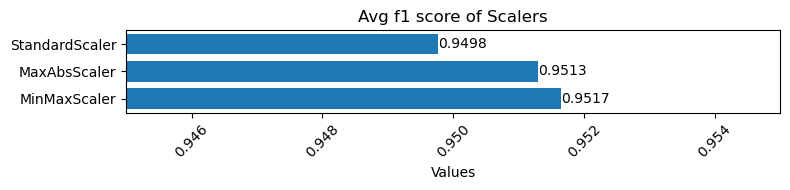

In [524]:
plot_bar_graphs(mean_df[mean_df.index.isin(top_df.scaler.unique())].sort_values(by='f1', ascending=False), ['f1'], title='Avg f1 score of Scalers', x_label='',horizontal=True, bar_min=0.945,bar_max=0.955, figsize=(8,2),grid=False, legend=False, decimal=4)

      Precision:   MinMaxScaler  
      Recall:   StandardScaler  
      F1:   MinMaxScaler  
    
### Winner: *MinMaxScaler*  

        
        
         
MinMax makes sense as the ideal scaler as word count cannot go below 0. The other two scaling methods, 'MaxAbsScaler' and 'StandardScaler' scale from -1 to 1 and make less sense for a word count feature. 

In [651]:
tt_df = results_df[(results_df['scaler'] == 'MinMaxScaler') & (results_df['split_method'] == 'tt')].set_index('model')
sss_df = results_df[(results_df['scaler'] == 'MinMaxScaler') & (results_df['split_method'] == 'sss')].set_index('model')
skf_df = results_df[(results_df['scaler'] == 'MinMaxScaler') & (results_df['split_method'] == 'skf')].set_index('model')

In [526]:
round(results_df[results_df.model=='SVMSigmoid']['accuracy'].mean(),2)

0.85

 
    SVM with Sigmoid kernel is by far the worst performer. SVM with Sigmoid provides only 85% accuracy on average. Compared to simply predicting all emails as spam, that is only a 15% increase. This model does not work for this problem.

In [652]:
tt_df = tt_df[tt_df['accuracy'] > 0.85]
sss_df = sss_df[sss_df['accuracy'] > 0.85]
skf_df = skf_df[skf_df['accuracy'] > 0.85]

Despite having high precision, LightGBM & ADABoost200 have a higher recall, showing they classify spam aggressively, meaning that real emails would be caught more often than spam emails would be classified as real, and allowed into inboxes.  
  
  I have chosen to prioritize precision over recall as real emails being filtered away as spam is more important than the user having to delete a few spam emails every now and then. 

In [654]:
tt_df['precision_recall_diff'] = tt_df['precision'] - tt_df['recall']
sss_df['precision_recall_diff'] = sss_df['precision'] - sss_df['recall']
skf_df['precision_recall_diff'] = skf_df['precision'] - skf_df['recall']

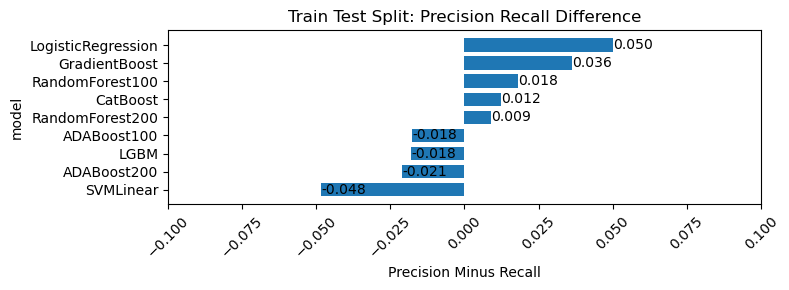

In [676]:
plot_bar_graphs(tt_df.sort_values(by='precision_recall_diff'), ['precision_recall_diff'], y_label='Precision Minus Recall',title='Train Test Split: Precision Recall Difference', horizontal=True, bar_min=-0.1, bar_max=0.1,figsize=(8,3),legend=False, grid=False)

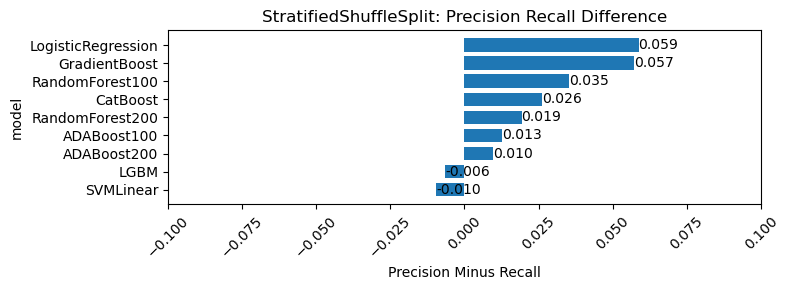

In [677]:
plot_bar_graphs(sss_df.sort_values(by='precision_recall_diff'), ['precision_recall_diff'], y_label='Precision Minus Recall',title='StratifiedShuffleSplit: Precision Recall Difference', horizontal=True, bar_min=-0.1, bar_max=0.1,figsize=(8,3),legend=False, grid=False)

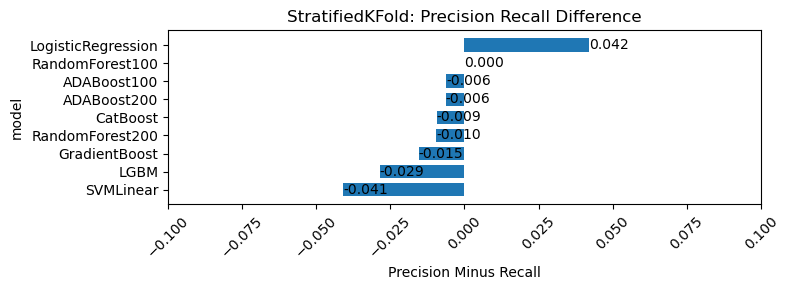

In [678]:
plot_bar_graphs(skf_df.sort_values(by='precision_recall_diff'), ['precision_recall_diff'], y_label='Precision Minus Recall',title='StratifiedKFold: Precision Recall Difference', horizontal=True, bar_min=-0.1, bar_max=0.1,figsize=(8,3),legend=False, grid=False)

ROC-AUC curve plots visualizes the number of real emails caught as spam, on the x-axis, relative to the number of spam emails caught as spam 

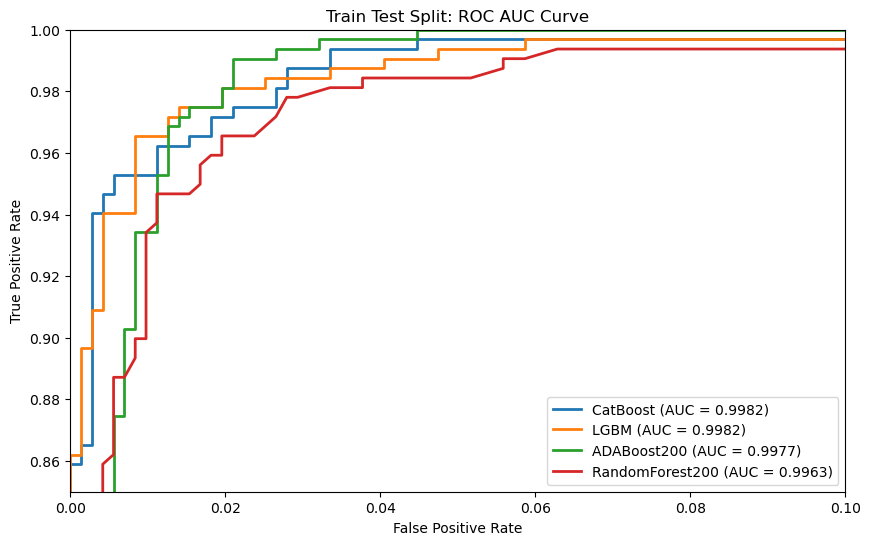

In [666]:
plt.figure(figsize=(10, 6))

for idx, row in tt_df.head(4).sort_values(by='roc_auc', ascending=False).iterrows():
    fpr, tpr, roc_thresholds = row['roc_curve']
    roc_auc = row['roc_auc']
    label = idx 
    plot_roc_curve(fpr, tpr, roc_auc, title='Train Test Split: ROC AUC Curve',  x_max = 0.1, y_min=0.85, label=label)

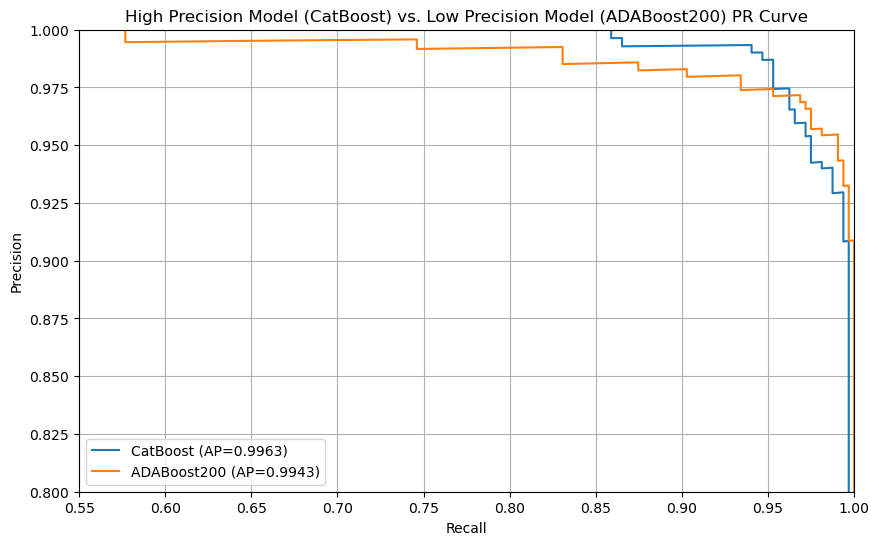

In [675]:
plt.figure(figsize=(10, 6)) 

for idx, row in tt_df.loc[['CatBoost','ADABoost200']].iterrows():
    pr = row['precision_recall']
    ap = row['average_precision']
    plot_pr_curve(pr, ap, title='High Precision Model (CatBoost) vs. Low Precision Model (ADABoost200) PR Curve', x_min=0.55, y_min=0.8, label=idx)
    
plt.show()

You can see ADABoost200 incorrectly classifies a non-spam email, a false positive, a lot earlier than CatBoost.  

ADABoost200, despite performing worse than CatBoost altogether by 0.2%, would provide a more valid model if recall was a higher priority. 

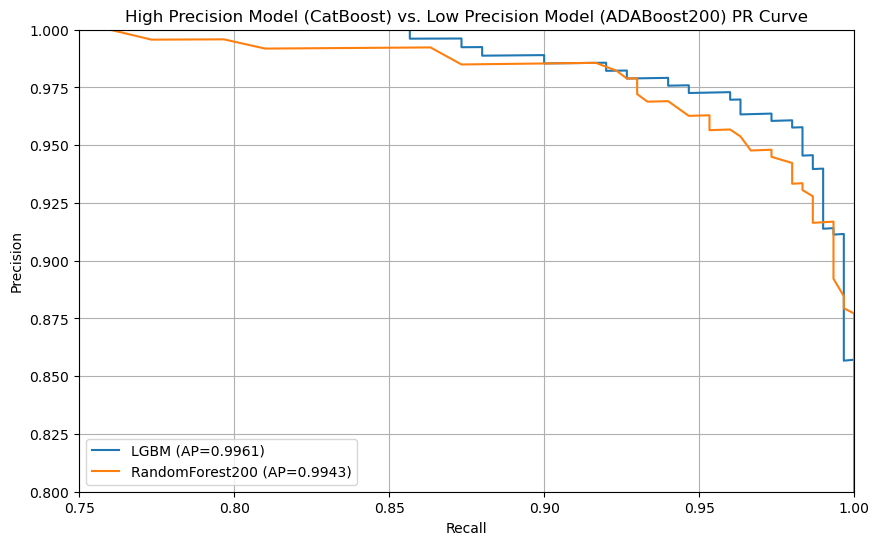

In [709]:
plt.figure(figsize=(10, 6)) 

for idx, row in skf_df.loc[['LGBM','RandomForest200']].iterrows():
    pr = row['precision_recall']
    ap = row['average_precision']
    plot_pr_curve(pr, ap, title='High Precision Model (CatBoost) vs. Low Precision Model (ADABoost200) PR Curve', x_min=0.75, y_min=0.8, label=idx)
    
plt.show()

Below dictionaries store dataframes of all the inflection points in the above PR curve graphs using the changes in precision relative to the change in recall

In [695]:
tt_diffs = df_to_diff_dc(tt_df)
skf_diffs = df_to_diff_dc(skf_df)
sss_diffs = df_to_diff_dc(sss_df)

### Thresholds Explained: 
   The first threshold, 80.95%, which means in order for an email to be classified as spam, the model must be over 81% certain it is spam. This threshold is also the level required so that 0% of real emails are a 'false positive' and erroneously detected as spam by the model. 
  
   The final threshold of 5.64% means that in order to get to 100% recall (no spam emails in inbox), the model will have to only be 5% certain an email is spam. 
>Where does recall make the largest gain? How much does precision drop at the same time? To maximize precision, while keeping recall relatively high, which threshold should be chosen?

In [710]:
tt_diffs['CatBoost'].reset_index(drop=True).set_index('threshold')

,precision,recall,precision_diff,recall_diff,f1
threshold,,,,,
0.8095,1.000000,0.858934,0.000000,0.000000,0.924115
0.7779,0.996390,0.865204,-0.003610,0.006270,0.926174
0.6129,0.993377,0.940439,-0.003012,0.075235,0.966184
0.5766,0.990164,0.946708,-0.003214,0.006270,0.967949
0.5369,0.987013,0.952978,-0.003151,0.006270,0.969697
0.4965,0.974603,0.962382,-0.012410,0.009404,0.968454
0.4809,0.965517,0.965517,-0.009086,0.003135,0.965517
0.4309,0.959752,0.971787,-0.005765,0.006270,0.965732
0.4234,0.953988,0.974922,-0.005765,0.003135,0.964341


This same information is plotted below, using the first 6 thresholds, since they are where precision is highest. 

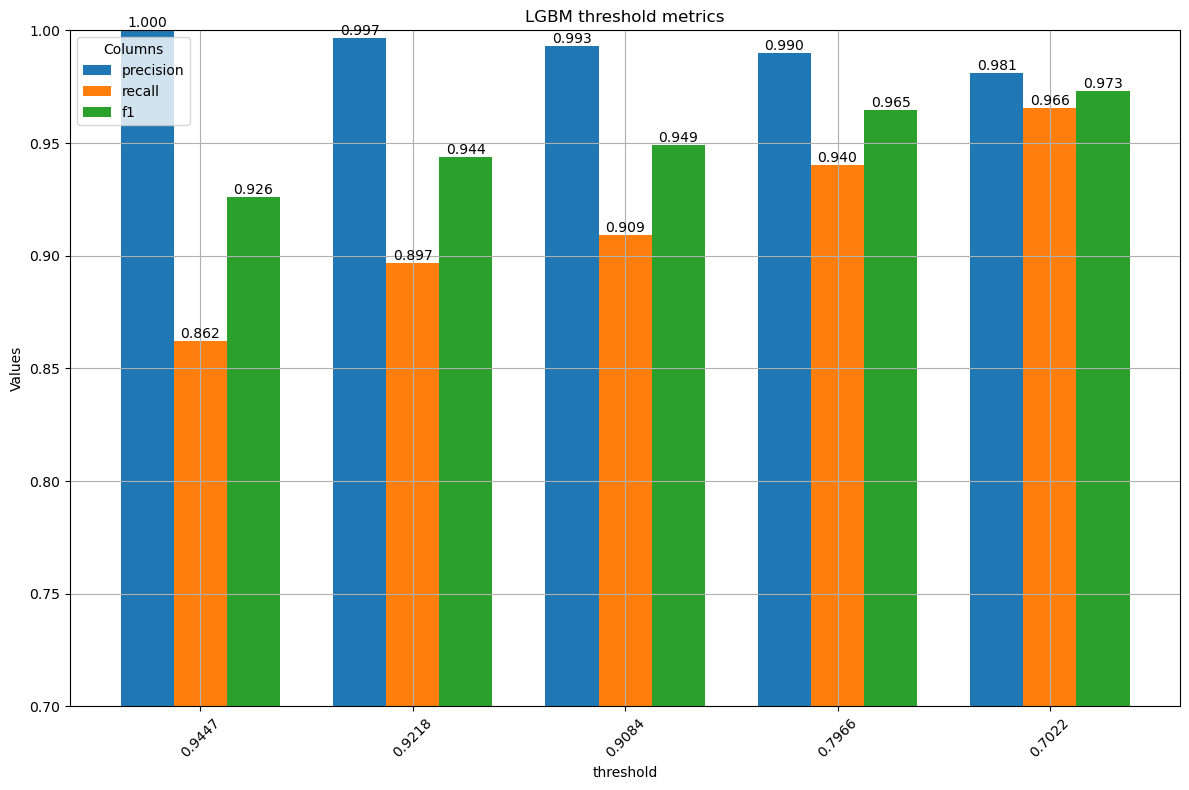

In [740]:
plot_bar_graphs(tt_diffs['LGBM'].reset_index(drop=True).set_index('threshold').sort_values(by='precision',ascending=False).head(5), ['precision','recall','f1'], title ='LGBM threshold metrics', horizontal=False, bar_min=0.7, figsize=(12,8))

Of all models, LightGBMClassifier (LGBM) shows the highest recall while ensuring perfect precision. 
>0.926 f1-score: 94.47% threshold, 100% precision, 86.2% recall

This means you can expect 13.8% of spam emails to sneak into the inbox, while making sure 100% of all real emails enter the inbox as intended, and aren't caught as spam.

In [739]:
tt_diffs['LGBM'].loc[[714,676]][['threshold','precision','recall','f1']]

,threshold,precision,recall,f1
714,0.9447,1.000000,0.862069,0.925926
676,0.7022,0.980892,0.965517,0.973144


A balanced, highly powerful model, if valuing both precision and recall equally, is the last graph:
  >0.973 f1-score: 59.7% threshold, 97.2% precision, 97.2% recall
 
 This means 2.8% of spam emails will sneak into the inbox while 2.8% of real emails will be filtered as spam.

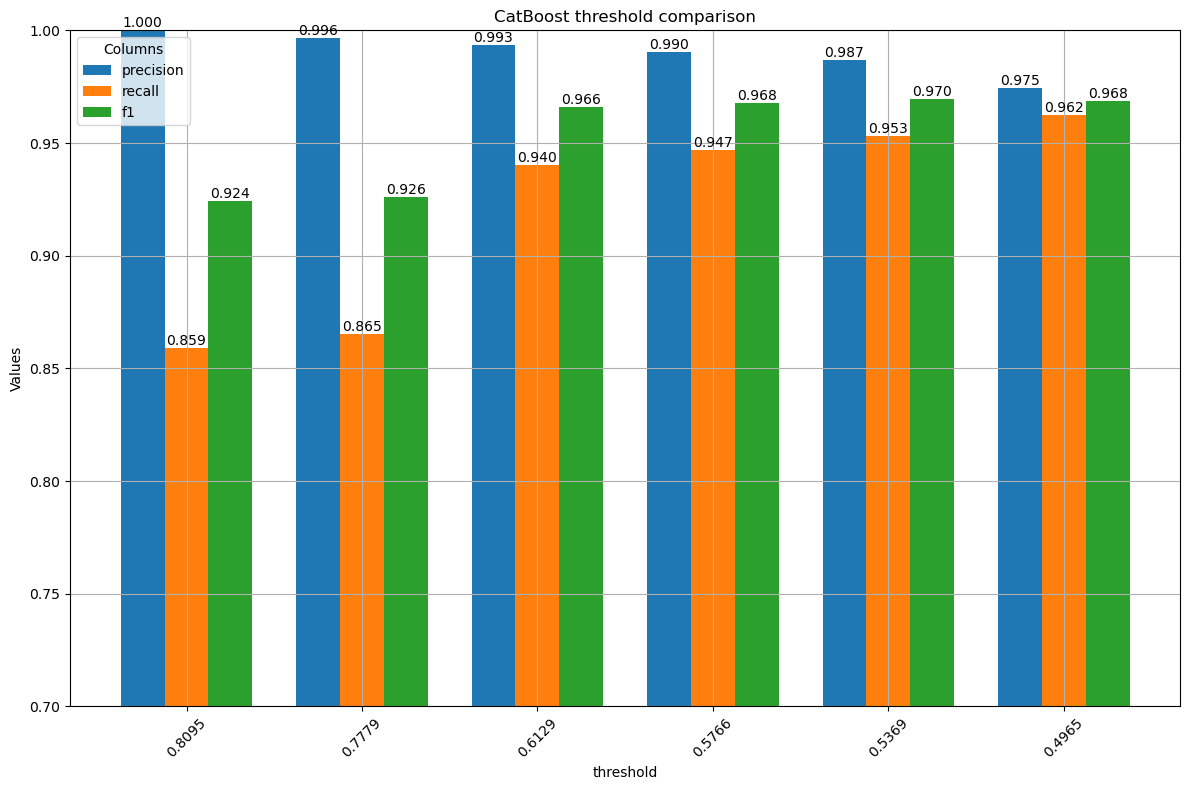

In [698]:
plot_bar_graphs(tt_diffs['CatBoost'].reset_index(drop=True).set_index('threshold').sort_values(by='precision',ascending=False).head(6), ['precision','recall','f1'], title='CatBoost threshold comparison', horizontal=False, bar_min=0.7, figsize=(12,8))

CatBoost has very similar numbers to LightGBMClassifier, but offers a solid option in the third set of bars:
>0.966 f1 score: 61.29% threshold, 99.3% precision, 94% recall

Compare this to 77.79% classification threshold, where precision is 99.6%, a mild gain, while recall and f1-score fall to 86.5% and 92.6, respectively.  
  
  This model and threshold level offers a false positive rate of 0.7% (real emails caught as spam), while also allowing 6% of spam emails into the inbox. 

In [733]:
tt_diffs['CatBoost'].loc[716:692][['threshold','precision','recall','f1']]

,threshold,precision,recall,f1
716,0.7779,0.996390,0.865204,0.926174
692,0.6129,0.993377,0.940439,0.966184


Is there a model that could prioritize recall more than precision? One that maximizes recall while not sacrificing precision? StandardScaler and StratifiedKFold showed the most promise for recall. 

In [715]:
skf_ss_df = results_df[(results_df['scaler'] == 'StandardScaler') & (results_df['split_method'] == 'skf')].set_index('model')
skf_ss_df = skf_ss_df[skf_ss_df['accuracy'] > 0.85]

skf_ss_diffs = df_to_diff_dc(skf_ss_df)

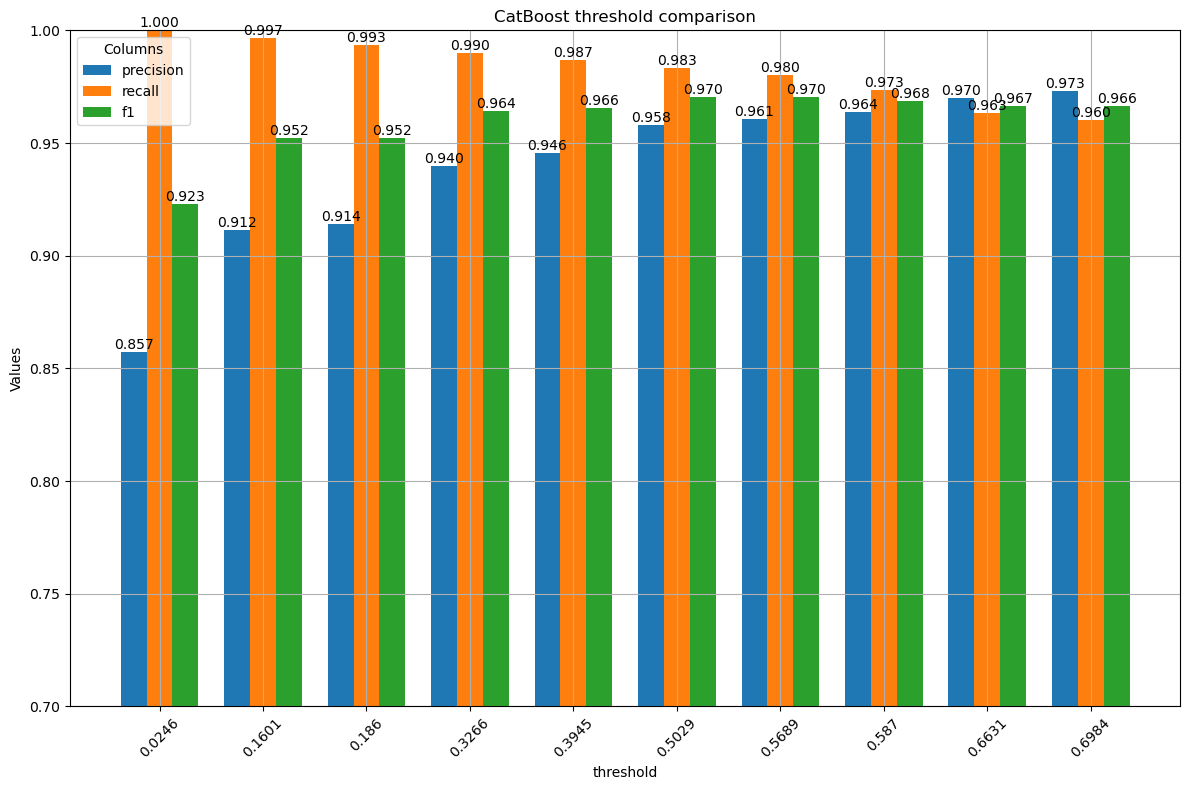

In [746]:
plot_bar_graphs(skf_ss_diffs['LGBM'].reset_index(drop=True).set_index('threshold').sort_values(by='recall',ascending=False).head(10), ['precision','recall','f1'], title='CatBoost threshold comparison', horizontal=False, bar_min=0.7, figsize=(12,8))

In [750]:
skf_ss_diffs['LGBM'].loc[669][['threshold','precision','recall','f1']]

threshold    0.502900
precision    0.957792
recall       0.983333
f1           0.970395
Name: 669, dtype: float64

>97.0 f1-score, 50.29% threshold, 95.78% precision, 98.33% recall

In [770]:
models_to_consider = [tt_diffs['LGBM'].loc[[676]],
            tt_diffs['LGBM'].loc[[714]],
            skf_ss_diffs['LGBM'].loc[[669]],
            tt_diffs['CatBoost'].loc[[716]],
            tt_diffs['CatBoost'].loc[[692]]]
                               

In [788]:
final_df = pd.concat(models_to_consider)

final_df.loc[[716, 692], 'model'] = 'CatBoost'
final_df.loc[[676, 714, 669], 'model'] = 'LGBM'

for idx,row in final_df.iterrows():
    if idx == 669:
        final_df.loc[idx,'scaler'] = 'StandardScaler'
        final_df.loc[idx,'split_method'] = 'StratifiedKFold'        
    else:
        final_df.loc[idx,'scaler'] = 'MinMaxScaler'
        final_df.loc[idx,'split_method'] = 'TrainTestSplit'
final_df = final_df[['model','scaler','split_method','threshold','precision','recall','f1']].reset_index(drop=True)
final_df

,model,scaler,split_method,threshold,precision,recall,f1
0,LGBM,MinMaxScaler,TrainTestSplit,0.7022,0.980892,0.965517,0.973144
1,LGBM,MinMaxScaler,TrainTestSplit,0.9447,1.000000,0.862069,0.925926
2,LGBM,StandardScaler,StratifiedKFold,0.5029,0.957792,0.983333,0.970395
3,CatBoost,MinMaxScaler,TrainTestSplit,0.7779,0.996390,0.865204,0.926174
4,CatBoost,MinMaxScaler,TrainTestSplit,0.6129,0.993377,0.940439,0.966184


### In Conclusion  

  >The most lenient spam filter, LGBM with MinMaxScaler & TrainTestSplit with 94.47% threshold obtains Perfect precision, 0% of real emails classified as spam, sacrificing a 14% False Negative Rate, (14% of spam emails allowed into inbox). f1-score: 0.926

>The most aggressive spam filter, LGBM with StandardScaler with StratifiedKFold at a 50.29% classification threshold, allowing only 1.7% of spam, but also classifying 4.3% of real emails as spam. f1-score: 0.97
  
  >A more lenient spam filter, CatBoost with MinMaxScaler, TrainTestSplit, set at a threshold of 61.29%, sacrifices 6% of spam emails in the inbox for 99.3% of real emails in the inbox, obtaining the 2nd best overall performance with an f1-score of 0.966
   
  >The most proficient, balanced model, LGBM with MinMaxScaler & TrainTestSplit with 70.22% threshold, filters 2% of real emails as spam, while allowing 3.45% of spam emails into the inbox. f1-score: 0.973

In [690]:
def df_to_diff_dc(df):
    pr_curve_dc = {}
    precision_drop_dc = {}

    for idx, row in df.iterrows():
        pr_curve_dc[idx] = create_pr_df(row)[0]
        precision_drop_dc[idx] = create_pr_df(row)[1]

    diffs = create_diff_within(precision_drop_dc)  
    return diffs

In [694]:
def create_diff_within(dc):
    for k,v in dc.items():
        v['precision_diff'] = v['precision'].diff().fillna(0)
        v['recall_diff'] = v['recall'].diff().fillna(0)
        v['f1'] = 2 * (v['precision'] * v['recall']) / (v['precision'] + v['recall'] + 1e-10) 
        v['threshold'] = round(v['threshold'],4)
        v = v.reset_index(drop=True).set_index('threshold')
    return dc

In [126]:
def create_pr_df(row):

    cb_p, cb_r, cb_th = row['precision_recall']
    
    cb_r = cb_r
    cb_p = cb_p
    cb_th = np.append(0, cb_th)

    cb_pr_df = pd.DataFrame({
    'threshold': cb_th,
    'precision': cb_p,
    'recall': cb_r
    })
    
    return cb_pr_df, cb_pr_df[cb_pr_df.index.isin(find_drops(cb_p))].sort_values(by='precision', ascending=False)

In [48]:
def find_drops(y):
  
    diffs = np.diff(y)
    
    return np.where(np.diff(np.sign(diffs)) < 0)[0] + 1


In [29]:
def plot_bar_graphs(df, columns, title='Model Performance Comparison', x_label=None, y_label='Values', horizontal=False, bar_min=0.90, bar_max=1.00, figsize=(14, 8), legend=True, grid=True, decimal=3):
    if x_label is None:
        x_label = df.index.name if df.index.name is not None else 'Index'

    num_cols = len(columns)
    width = 0.75 / num_cols
    x = range(len(df))
    
    plt.figure(figsize=figsize)
    
    # Collect handles and labels for the legend
    handles = []
    labels = []
    
    if horizontal:
        for i, col in enumerate(columns):
            if col in df.columns:
                offset = width * (i - (num_cols - 1) / 2)
                bars = plt.barh([p + offset for p in x], df[col], height=width, label=col)
                
                # Collect the handle and label
                handles.append(bars[0])
                labels.append(col)
                
                for bar in bars:
                    label_x = bar.get_width()
                    label_y = bar.get_y() + bar.get_height()/2
                    plt.text(label_x, label_y, f'{label_x:.{decimal}f}', ha='left', va='center', fontsize=10)
                
        plt.xlabel(y_label)
        plt.ylabel(x_label)
        plt.yticks(ticks=[p + width * ((num_cols - 1) / 2) for p in x], labels=df.index)
        plt.xticks(rotation=45)
        plt.xlim(left=bar_min, right=bar_max)

    else:
        for i, col in enumerate(columns):
            if col in df.columns:
                offset = width * (i - (num_cols - 1) / 2)
                bars = plt.bar([p + offset for p in x], df[col], width=width, label=col)
                
                # Collect the handle and label
                handles.append(bars[0])
                labels.append(col)
                
                for bar in bars:
                    label_x = bar.get_x() + bar.get_width()/2
                    label_y = bar.get_height()
                    plt.text(label_x, label_y, f'{bar.get_height():.{decimal}f}', ha='center', va='bottom', fontsize=10)

        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.xticks(ticks=x, labels=df.index, rotation=45)
        plt.ylim(bottom=bar_min, top=bar_max)
    
    plt.title(title)
    if legend:
        # Reverse the order of handles and labels if the plot is horizontal
        if horizontal:
            handles = handles[::-1]
            labels = labels[::-1]
        plt.legend(handles=handles, labels=labels, title='Columns')
    plt.grid(grid)
    plt.tight_layout()
    
    plt.show()

In [30]:
def plot_roc_curve(fpr, tpr, roc_auc, title='ROC Curve', x_min=0, x_max = 0.125, y_min=0.875, y_max=1.0, label=None):
    plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlim([x_min, x_max])
    plt.ylim([y_min, y_max])  
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')


In [31]:
def plot_pr_curve(precision_recall, average_precision, title='Precision-Recall Curve', x_min=0.75, x_max=1.0, y_min=0.75, y_max=1, label=None):

    precision, recall, _ = precision_recall

    plt.plot(recall, precision, label=f'{label} (AP={average_precision:.4f})')
    plt.xlim([x_min, x_max])
    plt.ylim([y_min, y_max])    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(title)
    plt.legend(loc='best')
    plt.grid(True)

In [246]:
def rp_curve(df, idx):

    p_arr = df.loc[idx,'precision_recall'][0]
    r_arr = df.loc[idx,'precision_recall'][1]
    th_arr = df.loc[idx,'precision_recall'][2]
    avg_r = np.mean(r_arr)
    plot_pr_curve((r_arr,p_arr,th_arr), avg_r, title='Initial Precision Drops', x_min=0.75,x_max=1, y_min=0.75, label=idx)

In [217]:
#for k in precision_drop_dc.keys():
    #plot_bar_graphs(precision_drop_dc[k].reset_index(drop=True).set_index('threshold').sort_values(by='precision',ascending=False).head(6), ['precision','recall','f1'], title=k + ' threshold metrics', horizontal=False, bar_min=0.4, figsize=(12,8))